In [1]:
import matplotlib.pyplot as plt
import numpy as np

from astropy.table import Table

from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

In [2]:
from utils.ufunc import CW, coords_to_xyz, cal_r200

# Load data

In [3]:
grps = Table.read("./data/group_DR7/modelA_group", format = 'ascii')

grps['col1'].name = 'id'
grps['col2'].name = 'RA'
grps['col3'].name = 'dec'
grps['col4'].name = 'z'
grps['col5'].name = 'L'
grps['col6'].name = 'sm'
grps['col7'].name = 'hm1'
grps['col8'].name = 'hm2'
grps['col9'].name = 'mean_sep1'
grps['col10'].name = 'mean_sep2'
grps['col11'].name = 'f_edge'
grps['col12'].name = 'ID1'
grps['col13'].name = 'ID2'

In [4]:
cat = Table.read("./data/s82grfn.fit")

ra_gal = cat['RAJ2000'].value
dec_gal = cat['DEJ2000'].value
zz_gal = cat['z'].value

dist_gal = cosmo.comoving_distance(zz_gal).value # Mpc

coords_gal = SkyCoord(ra = ra_gal * u.degree, dec = dec_gal * u.degree, distance = dist_gal * u.Mpc)

x_gal = coords_gal.cartesian.x
y_gal = coords_gal.cartesian.y
z_gal = coords_gal.cartesian.z

## 1. Effect of varying linking lenth for a given halo mass cut

* Redshift: $0.015 < z < 0.055$
* Halo mass: $2e12$. $5e12$, $1e13$

In [7]:
mask_clusters = []
mask_filaments = []
mask_tendrils = []
mask_voids = []

for hm_cut in [2e12, 5e12, 1e13]:
    
    mask_m = (grps['hm1'] > np.log10(hm_cut))
    mask_z = (grps['z'] > 0.015) & (grps['z'] < 0.055)
    mask_coord = ((grps['RA'] < 70) | (grps['RA'] > 290)) & ((grps['dec'] < 5) & (grps['dec'] > -5))

    #final mask
    mask_grp = mask_m & mask_z & mask_coord

    grps_test = grps[mask_grp]
    print(f'{sum(mask_grp)} clusters more massive than {hm_cut:.2e}')
    
    
    x_grp, y_grp, z_grp = coords_to_xyz(grps_test['RA'], grps_test['dec'], grps_test['z'])
    
    ll_cl = 5.75
    ll_fil = 4.12
    ll_tdr = 3.0
    r200 = cal_r200(10**grps_test['hm2'], grps_test['z'])
    cw = CW([x_grp, y_grp, z_grp], [x_gal, y_gal, z_gal], ll_cl, ll_fil, ll_tdr)
    mask_cl = cw.cal_mask_cluster(r200)
    mask_fl = cw.cal_mask_filament()
    mask_tdr = cw.cal_mask_tendril()
    mask_vd = cw.cal_mask_tendril()
    
    mask_clusters.append(mask_cl)
    mask_filaments.append(mask_fl)
    mask_tendrils.append(mask_tdr)
    mask_voids.append(mask_vd)
    
    print(f'\tgals in cluster: {sum(mask_cl):d}')
    print(f'\tgals in filament: {sum(mask_fl):d}')
    print(f'\tgals in tendril: {sum(mask_tdr):d}')
    print(f'\tgals in void: {sum(mask_vd):d}\n')

248 clusters more massive than 2.00e+12
	gals in cluster: 177
	gals in filament: 1205
	gals in tendril: 11643
	gals in void: 11643

91 clusters more massive than 5.00e+12
	gals in cluster: 85
	gals in filament: 267
	gals in tendril: 12677
	gals in void: 12677

53 clusters more massive than 1.00e+13
	gals in cluster: 67
	gals in filament: 131
	gals in tendril: 12829
	gals in void: 12829



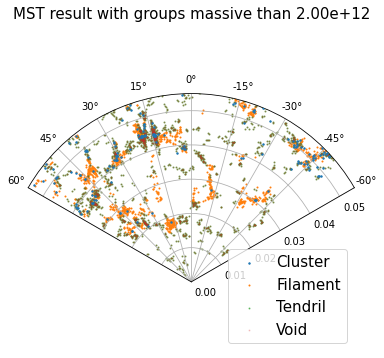

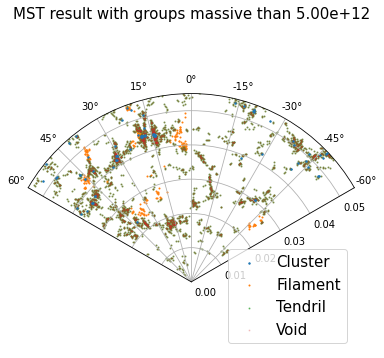

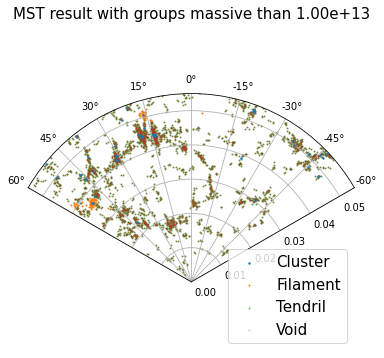

In [15]:
hm_cuts = [2e12, 5e12, 1e13]

for ii in range(3):
    fig, ax = plt.subplots(figsize = (8, 6), subplot_kw={'projection': 'polar'})

    theta_gal = ra_gal * np.pi / 180

    ax.scatter(theta_gal[mask_clusters[ii]], zz_gal[mask_clusters[ii]], s = 2, label = 'Cluster', zorder = 3)
    ax.scatter(theta_gal[mask_filaments[ii]], zz_gal[mask_filaments[ii]], s = 1, label = 'Filament')
    ax.scatter(theta_gal[mask_tendrils[ii]], zz_gal[mask_tendrils[ii]], s = 1, label = 'Tendril', alpha = .6)
    ax.scatter(theta_gal[mask_voids[ii]], zz_gal[mask_voids[ii]], s = 1, label = 'Void', alpha = .2)


    ax.set_thetalim(-np.pi/3, np.pi/3)
    ax.set_rlim(0, 0.055)

    # ax.set_ylabel('redshift', fontsize = 15)
    # ax.yaxis.set_label_position('right')
    # ax.set_xlabel('RA [deg]', fontsize = 15)

    ax.legend(fontsize = 15)

    ax.set_theta_zero_location("N")
    ax.set_title(f'MST result with groups massive than {hm_cuts[ii]:.2e}', fontsize = 15)